<a href="https://colab.research.google.com/github/Sagargomad/My_projects/blob/main/Using_pre_trained_VGG16%2C_ResNet50_and_InceptionV3_networks_to_extract_bottleneck_features_and_building_a_model_on_top_of_each_of_them_to_evaluate_and_compare_the_model_performances_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,GlobalAveragePooling2D,Dropout
plt.rcParams['font.size']=14
from keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
import os

# Set the environment variable with the correct path to the uploaded JSON file.
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
!kaggle competitions download -c plant-seedlings-classification

 99% 1.68G/1.69G [00:14<00:00, 176MB/s]
100% 1.69G/1.69G [00:14<00:00, 124MB/s]


In [ ]:
import zipfile

# Define the path to the ZIP file and the target directory for extraction
zip_file_path = "/content/plant-seedlings-classification.zip"  # Replace with the actual path
extract_dir = "/content"  # Replace with the desired extraction path

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# List the contents of the extracted directory
extracted_files = os.listdir(extract_dir)
print("Extracted files:", extracted_files)

Extracted files: ['.config', 'test', 'train', 'sample_submission.csv', 'kaggle.json', 'plant-seedlings-classification.zip', 'sample_data']


In [ ]:
#Preprocessing of image
img_size = 224
batch_size = 32

datagen = ImageDataGenerator(rescale=1/255,
                            rotation_range=30,
                            brightness_range=[0.5,1.2],
                            horizontal_flip=True,
                            validation_split=0.25,
                            zoom_range=0.2)


train_generator = datagen.flow_from_directory('/content/train',
                                              target_size=(img_size,img_size),
                                              batch_size=batch_size,
                                              shuffle=True,
                                              subset='training',
                                              #color_mode='grayscale',
                                              class_mode='categorical')


val_generator = datagen.flow_from_directory('/content/train',
                                            target_size=(img_size,img_size),
                                            batch_size=batch_size,
                                            shuffle=False,
                                            subset='validation',
                                            #color_mode='grayscale',
                                            class_mode='categorical')

Found 3568 images belonging to 12 classes.
Found 1182 images belonging to 12 classes.


In [ ]:
#preprocessing test images
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                              data_format='channels_last')  # Specify 'channels_last' for PNG images
test_generator = test_datagen.flow_from_directory(
    directory='/content',
    classes=['test'],
    target_size=(img_size, img_size),
    batch_size=1,
    shuffle=False,
    class_mode='categorical')

Found 794 images belonging to 1 classes.


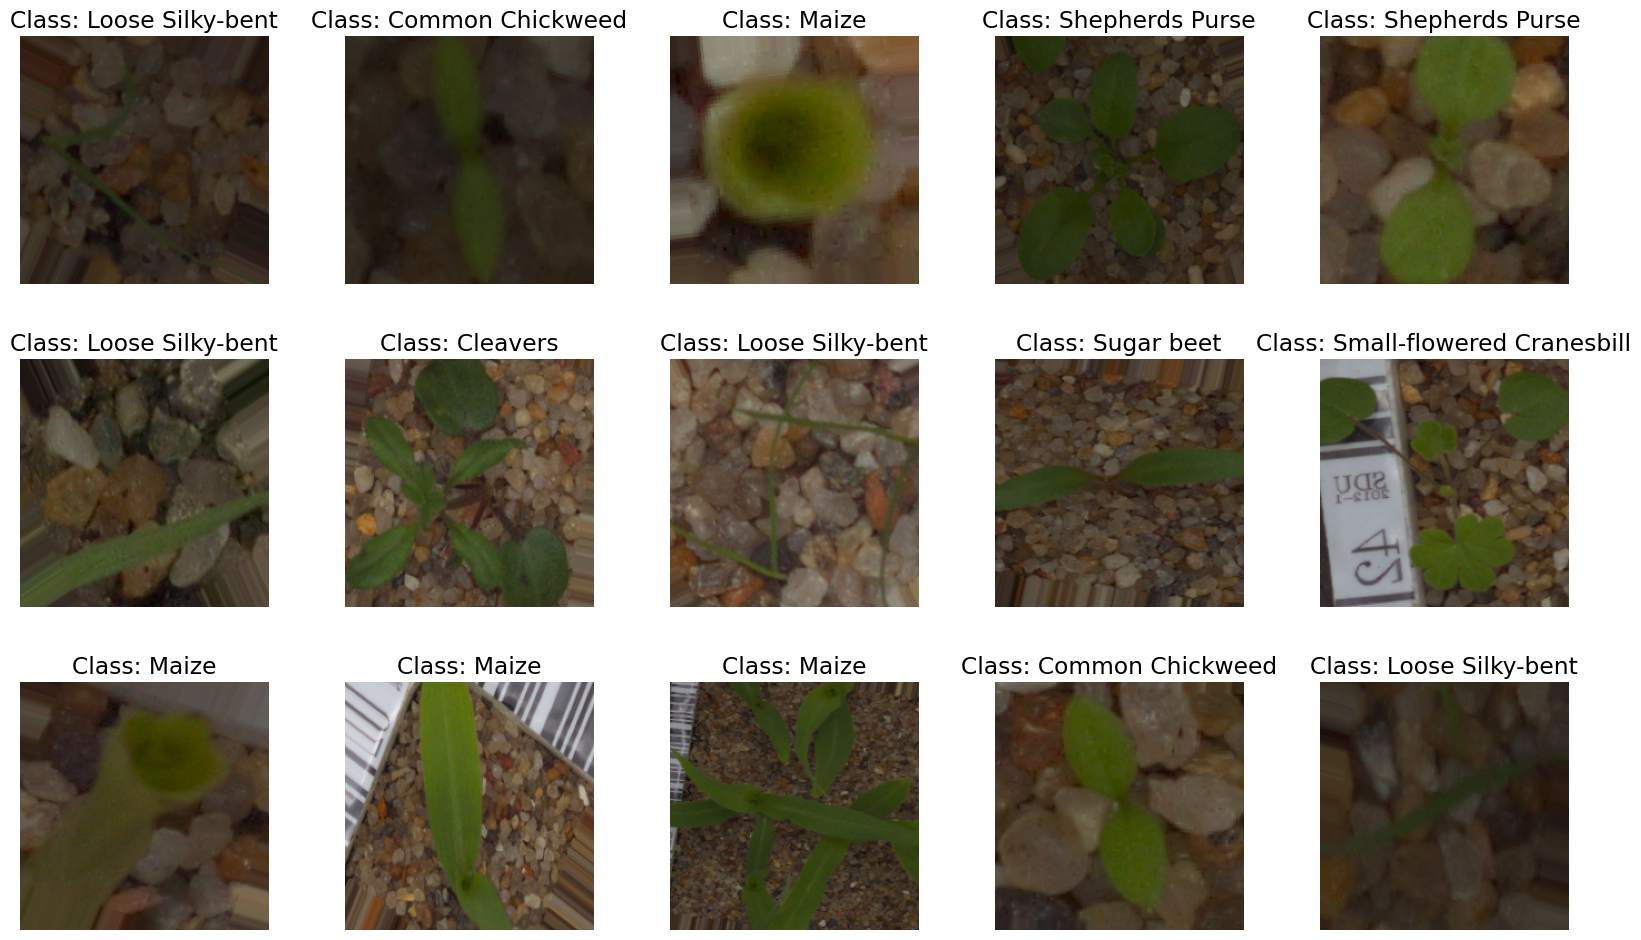

In [ ]:
#Plotting training images
label = [k for k in train_generator.class_indices]
samples = train_generator.__next__()
images = samples[0]
titles = samples[1]
plt.figure(figsize=(20,20))

for i in range(15):
    plt.subplot(5,5,i+1)
    plt.subplots_adjust(hspace=0.3,wspace=0.3)
    plt.imshow(images[i])
    plt.title(f"Class: {label[np.argmax(titles[i],axis=0)]}")
    plt.axis("off")

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


Creating VGG16 Model

In [ ]:
#create the mdel
base_model_1=tf.keras.applications.vgg16.VGG16(include_top=False,weights='imagenet',input_shape=(img_size,img_size,3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
#Frezzing some layers
for layer in base_model_1.layers[:3]:
    layer.trainable = False

In [ ]:
#Compile the model
last_output = base_model_1.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(12, activation='softmax')(x)
model_1 = Model(inputs=base_model_1.inputs,outputs=outputs)
model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
#Save the modeland add callbacks

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_name = "model_vgg.h5"
Checkpoint = ModelCheckpoint(model_name,monitor="val_loss",mode="min",save_best_only=True,verbose=1)
es = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
lrr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.3, min_lr=0.00000001)

In [ ]:
#Fit the model
history = model_1.fit(train_generator,epochs=50,validation_data=val_generator,callbacks=[Checkpoint,es,lrr])

Epoch 1/50
112/112 [==============================] - ETA: 0s - loss: 2.4724 - accuracy: 0.1197
Epoch 1: val_loss improved from inf to 2.42872, saving model to model_vgg.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 162s 1s/step - loss: 2.4724 - accuracy: 0.1197 - val_loss: 2.4287 - val_accuracy: 0.1083 - lr: 1.0000e-04
Epoch 2/50
112/112 [==============================] - ETA: 0s - loss: 2.4268 - accuracy: 0.1365
Epoch 2: val_loss did not improve from 2.42872
112/112 [==============================] - 125s 1s/step - loss: 2.4268 - accuracy: 0.1365 - val_loss: 2.4461 - val_accuracy: 0.1506 - lr: 1.0000e-04
Epoch 3/50
112/112 [==============================] - ETA: 0s - loss: 2.3239 - accuracy: 0.1897
Epoch 3: val_loss improved from 2.42872 to 2.14292, saving model to model_vgg.h5
112/112 [==============================] - 133s 1s/step - loss: 2.3239 - accuracy: 0.1897 - val_loss: 2.1429 - val_accuracy: 0.2673 - lr: 1.0000e-04
Epoch 4/50
112/112 [==============================] - ETA: 0s - loss: 1.9311 - accuracy: 0.3055
Epoch 4: val_loss improved from 2.14292 to 1.74363, saving model to model_vgg.h5
112/112 [==============================] - 125s 1s/step 

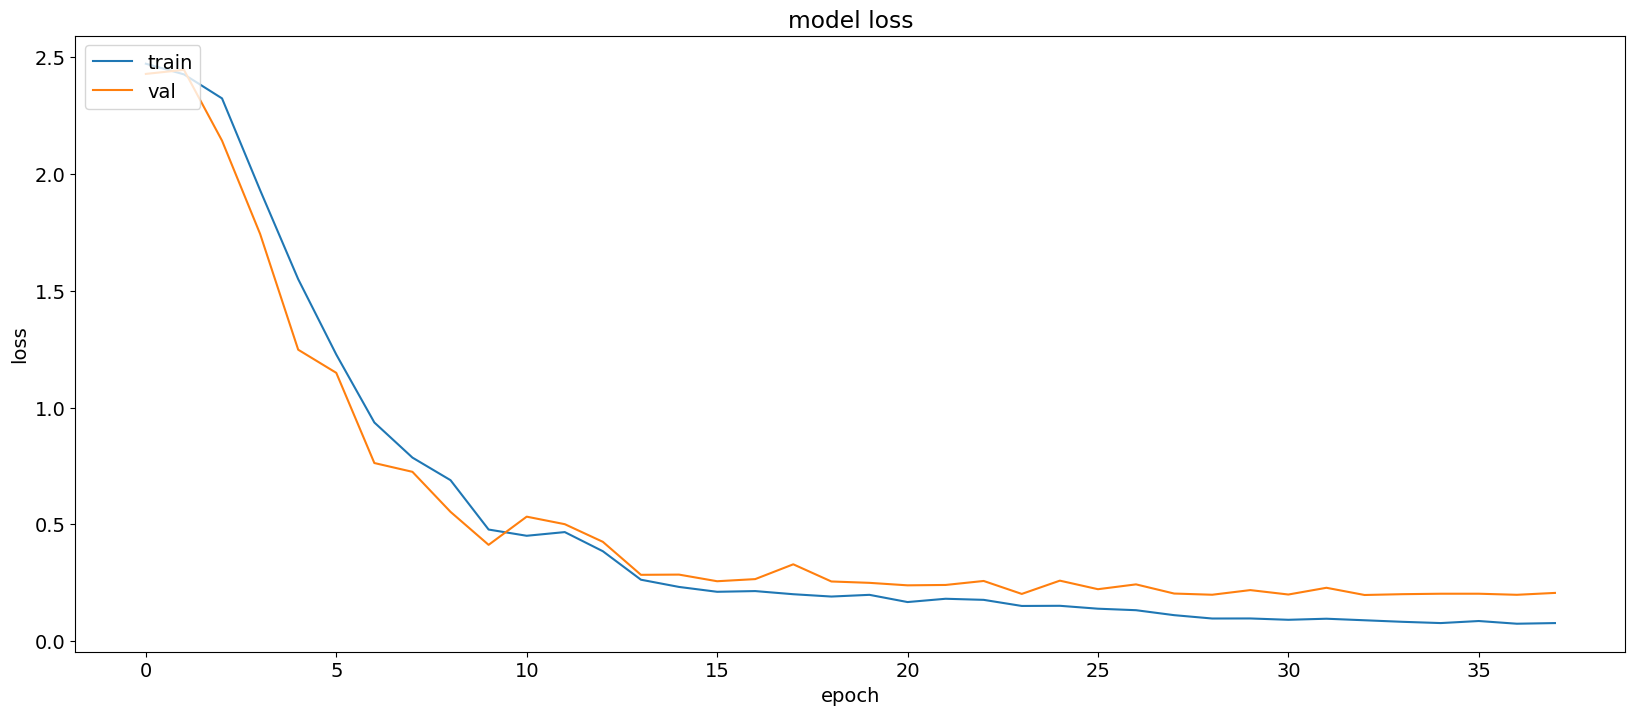

In [ ]:
#load the saved model
model = tf.keras.models.load_model("/content/model_vgg.h5")
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

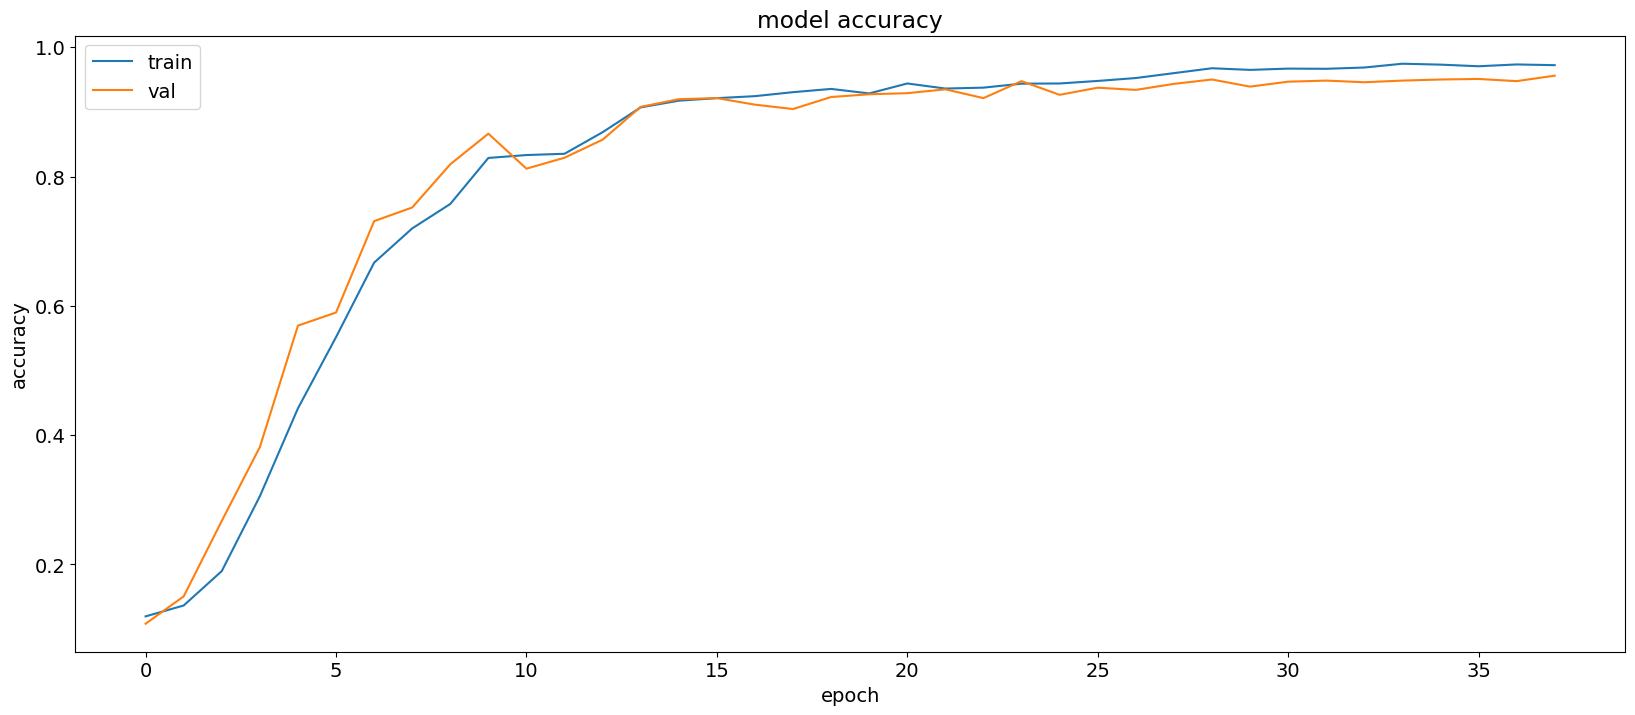

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_test = val_generator.classes
y_pred = model.predict(val_generator)
y_pred = np.argmax(y_pred,axis=1)

37/37 [==============================] - 29s 754ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,y_pred,target_names = label))

                           precision    recall  f1-score   support

              Black-grass       0.81      0.88      0.84        65
                 Charlock       0.96      0.99      0.97        97
                 Cleavers       0.96      0.93      0.94        71
         Common Chickweed       0.96      0.98      0.97       152
             Common wheat       0.94      0.93      0.94        55
                  Fat Hen       1.00      1.00      1.00       118
         Loose Silky-bent       0.95      0.95      0.95       163
                    Maize       0.96      0.95      0.95        55
        Scentless Mayweed       0.91      0.91      0.91       129
          Shepherds Purse       0.92      0.86      0.89        57
Small-flowered Cranesbill       1.00      0.98      0.99       124
               Sugar beet       0.99      0.97      0.98        96

                 accuracy                           0.95      1182
                macro avg       0.95      0.94      0.94    

Confusion Matrix:
[[ 57   0   0   0   1   0   6   1   0   0   0   0]
 [  0  96   0   0   0   0   0   0   0   0   0   1]
 [  0   2  66   1   1   0   0   0   1   0   0   0]
 [  0   0   0 149   0   0   1   0   2   0   0   0]
 [  3   0   0   0  51   0   0   0   1   0   0   0]
 [  0   0   0   0   0 118   0   0   0   0   0   0]
 [  8   0   0   0   0   0 155   0   0   0   0   0]
 [  1   0   0   0   1   0   0  52   1   0   0   0]
 [  0   0   1   5   0   0   1   0 118   4   0   0]
 [  0   0   0   1   0   0   0   0   7  49   0   0]
 [  0   1   1   0   0   0   0   1   0   0 121   0]
 [  1   1   1   0   0   0   0   0   0   0   0  93]]


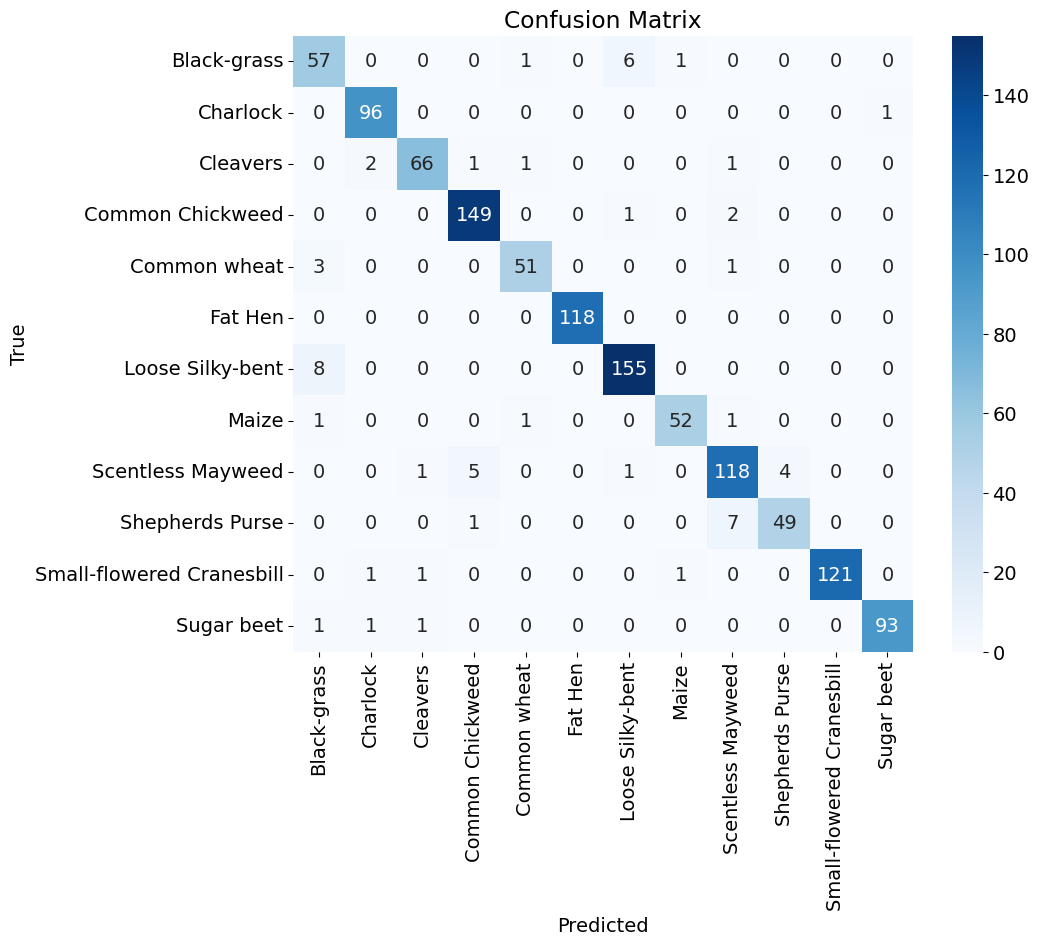

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Assuming y_test and y_pred contain your true labels and predicted labels
# Assuming label is a list of class labels

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Optionally, you can create a visual representation of the confusion matrix
# This is useful for a more intuitive understanding
import seaborn as sns
import matplotlib.pyplot as plt

# Define the labels for the confusion matrix
class_labels = label

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Save the model weights to a file
model.save_weights('model_vgg_weights.h5')

Create ResNet50 Model

In [ ]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(img_size,img_size,3))

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_22 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_22[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:


# Freeze some initial layers if needed
for layer in base_model.layers[:50]:
    layer.trainable = False
base_model.summary()



Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_22 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_22[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
# Create the custom top layers for your new model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(12, activation='softmax')(x)

# Create the new model by specifying input and output layers
model = Model(inputs=base_model.inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
#Save the modeland add callbacks

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_name = "modelds.h5"
Checkpoint = ModelCheckpoint(model_name,monitor="val_loss",mode="min",save_best_only=True,verbose=1)
es = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
lrr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.3, min_lr=0.00000001)

In [ ]:
#fit the model
history = model.fit(train_generator,epochs=50,validation_data=val_generator,
                    callbacks=[Checkpoint,es,lrr])

Epoch 1/50
112/112 [==============================] - ETA: 0s - loss: 2.0520 - accuracy: 0.3103
Epoch 1: val_loss improved from inf to 2.64501, saving model to modelds.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 164s 1s/step - loss: 2.0520 - accuracy: 0.3103 - val_loss: 2.6450 - val_accuracy: 0.0525 - lr: 1.0000e-04
Epoch 2/50
112/112 [==============================] - ETA: 0s - loss: 1.2094 - accuracy: 0.6003
Epoch 2: val_loss did not improve from 2.64501
112/112 [==============================] - 114s 1s/step - loss: 1.2094 - accuracy: 0.6003 - val_loss: 5.1348 - val_accuracy: 0.1379 - lr: 1.0000e-04
Epoch 3/50
112/112 [==============================] - ETA: 0s - loss: 0.8505 - accuracy: 0.7119
Epoch 3: val_loss did not improve from 2.64501
112/112 [==============================] - 118s 1s/step - loss: 0.8505 - accuracy: 0.7119 - val_loss: 3.3320 - val_accuracy: 0.1345 - lr: 1.0000e-04
Epoch 4/50
112/112 [==============================] - ETA: 0s - loss: 0.7176 - accuracy: 0.7522
Epoch 4: val_loss did not improve from 2.64501

Epoch 4: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
112/112 [==============================] - 114

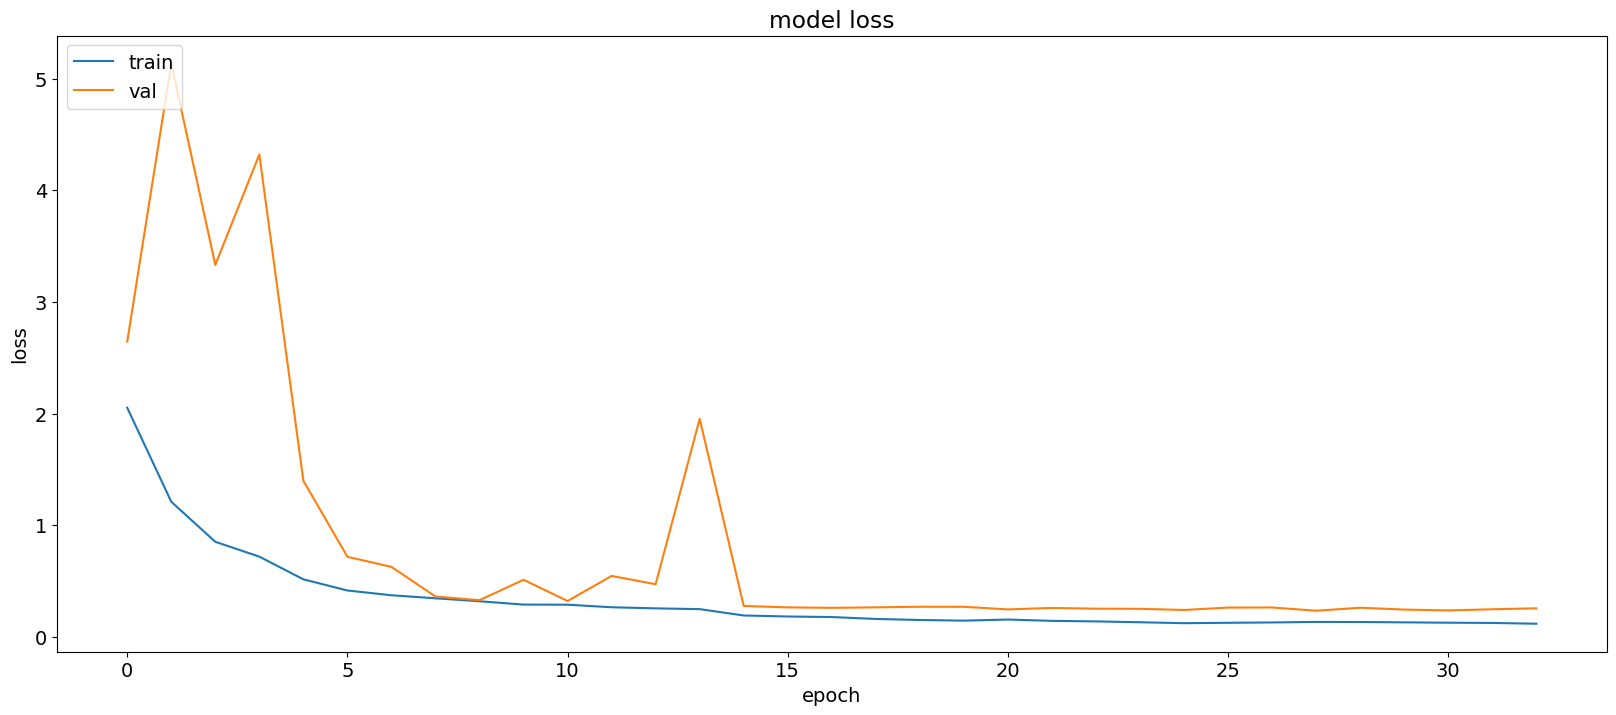

In [ ]:
#load the saved model
model = tf.keras.models.load_model("/content/modelds.h5")
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

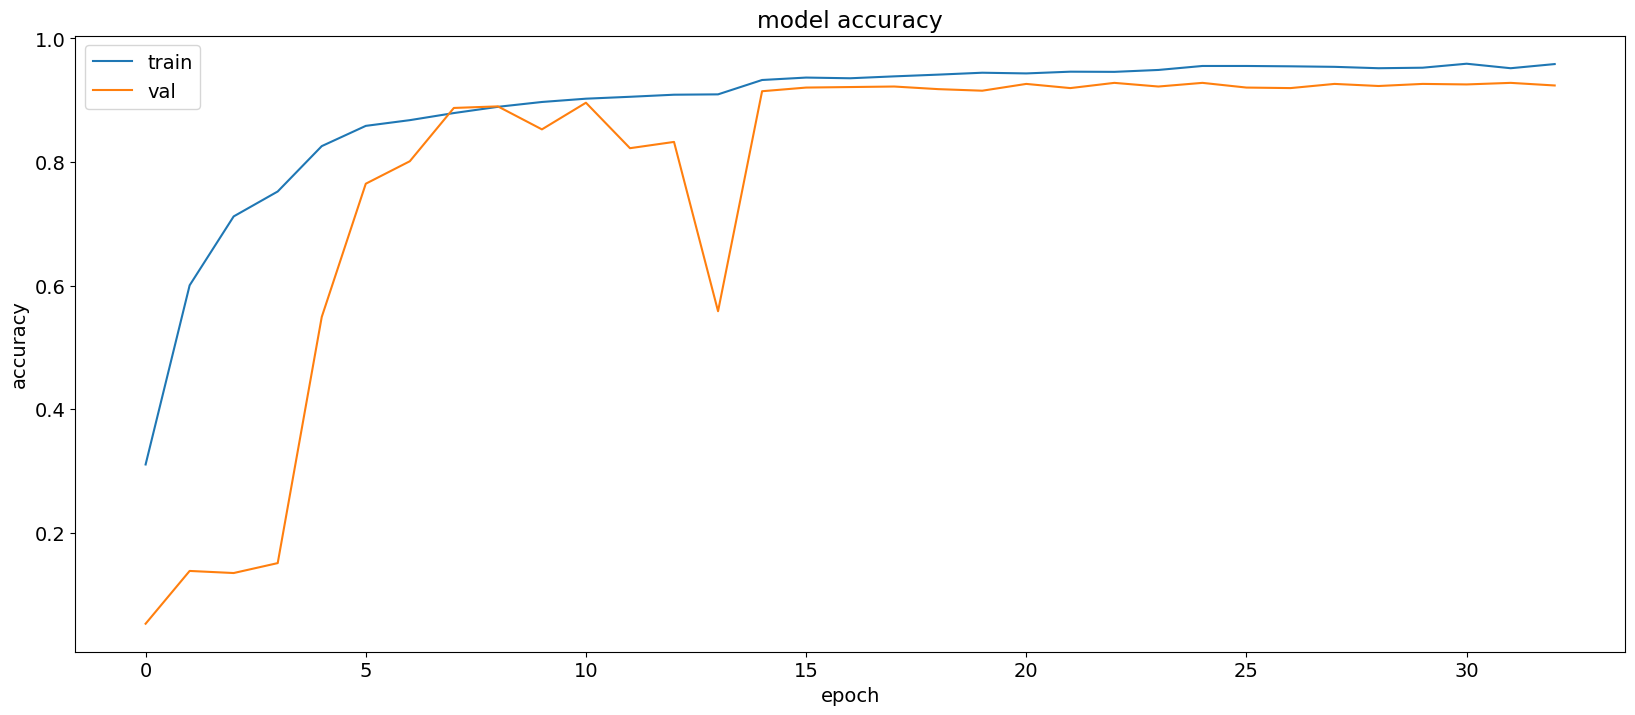

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_test = val_generator.classes
y_pred = model.predict(val_generator)
y_pred = np.argmax(y_pred,axis=1)

37/37 [==============================] - 30s 766ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,y_pred,target_names = label))

                           precision    recall  f1-score   support

              Black-grass       0.64      0.57      0.60        65
                 Charlock       0.98      0.98      0.98        97
                 Cleavers       0.92      0.93      0.92        71
         Common Chickweed       0.96      0.98      0.97       152
             Common wheat       0.95      0.98      0.96        55
                  Fat Hen       0.97      0.97      0.97       118
         Loose Silky-bent       0.83      0.88      0.86       163
                    Maize       0.91      0.96      0.94        55
        Scentless Mayweed       0.95      0.97      0.96       129
          Shepherds Purse       1.00      0.93      0.96        57
Small-flowered Cranesbill       1.00      0.98      0.99       124
               Sugar beet       1.00      0.93      0.96        96

                 accuracy                           0.93      1182
                macro avg       0.93      0.92      0.92    

Confusion Matrix:
[[ 37   0   0   0   2   0  26   0   0   0   0   0]
 [  0  95   2   0   0   0   0   0   0   0   0   0]
 [  0   1  66   1   0   1   0   1   1   0   0   0]
 [  0   0   1 149   0   0   1   0   1   0   0   0]
 [  1   0   0   0  54   0   0   0   0   0   0   0]
 [  1   1   1   0   0 115   0   0   0   0   0   0]
 [ 18   0   0   0   1   0 144   0   0   0   0   0]
 [  0   0   0   0   0   0   1  53   1   0   0   0]
 [  1   0   1   2   0   0   0   0 125   0   0   0]
 [  0   0   0   2   0   0   0   0   2  53   0   0]
 [  0   0   1   0   0   0   0   1   1   0 121   0]
 [  0   0   0   1   0   2   1   3   0   0   0  89]]


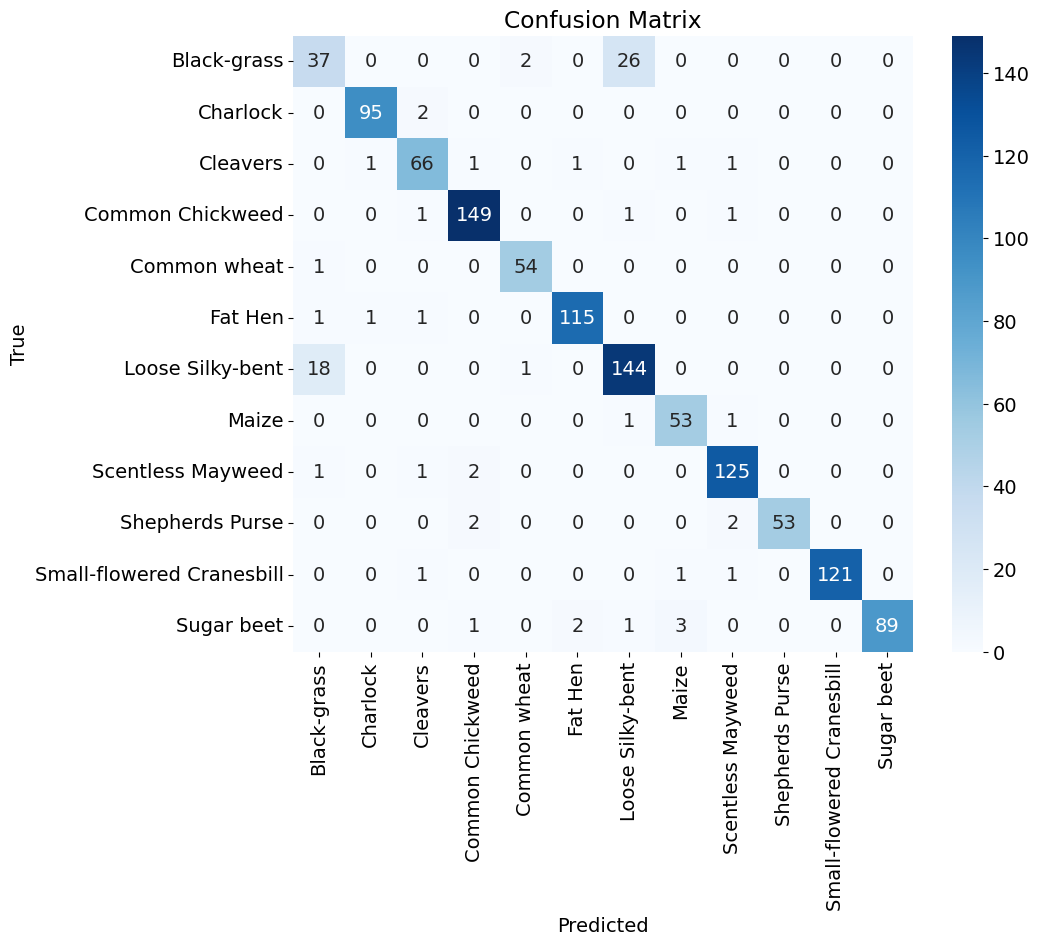

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Assuming y_test and y_pred contain your true labels and predicted labels
# Assuming label is a list of class labels

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Optionally, you can create a visual representation of the confusion matrix
# This is useful for a more intuitive understanding
import seaborn as sns
import matplotlib.pyplot as plt

# Define the labels for the confusion matrix
class_labels = label

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Save the model weights to a file
model.save_weights('model_weights.h5')


Creating Inception_V3 model

In [ ]:

from tensorflow.keras.applications.inception_v3 import InceptionV3


In [ ]:
base_model_2 = InceptionV3(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))


87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
# Freeze the first few layers
for layer in base_model_2.layers[:3]:
    layer.trainable = False

In [ ]:
# Add your custom output layers
last_output = base_model_2.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(12, activation='softmax')(x)

In [ ]:
# Create the InceptionV2-based model
model_2 = Model(inputs=base_model_2.inputs, outputs=outputs)

In [ ]:
# Compile the model
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
# Save the model and add callbacks
model_name = "model_inceptionv2.h5"
Checkpoint = ModelCheckpoint(model_name, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lrr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.3, min_lr=0.00000001)

In [ ]:
# Train the model
history = model_2.fit(train_generator, epochs=50, validation_data=val_generator, callbacks=[Checkpoint, es, lrr])

Epoch 1/50
112/112 [==============================] - ETA: 0s - loss: 1.2824 - accuracy: 0.5807
Epoch 1: val_loss improved from inf to 0.65356, saving model to model_inceptionv2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 192s 1s/step - loss: 1.2824 - accuracy: 0.5807 - val_loss: 0.6536 - val_accuracy: 0.7657 - lr: 1.0000e-04
Epoch 2/50
112/112 [==============================] - ETA: 0s - loss: 0.4064 - accuracy: 0.8649
Epoch 2: val_loss improved from 0.65356 to 0.41463, saving model to model_inceptionv2.h5
112/112 [==============================] - 133s 1s/step - loss: 0.4064 - accuracy: 0.8649 - val_loss: 0.4146 - val_accuracy: 0.8629 - lr: 1.0000e-04
Epoch 3/50
112/112 [==============================] - ETA: 0s - loss: 0.2754 - accuracy: 0.9036
Epoch 3: val_loss improved from 0.41463 to 0.35819, saving model to model_inceptionv2.h5
112/112 [==============================] - 121s 1s/step - loss: 0.2754 - accuracy: 0.9036 - val_loss: 0.3582 - val_accuracy: 0.8824 - lr: 1.0000e-04
Epoch 4/50
112/112 [==============================] - ETA: 0s - loss: 0.2044 - accuracy: 0.9297
Epoch 4: val_loss improved from 0.35819 to 0.24236, saving model to model_inceptionv2.h

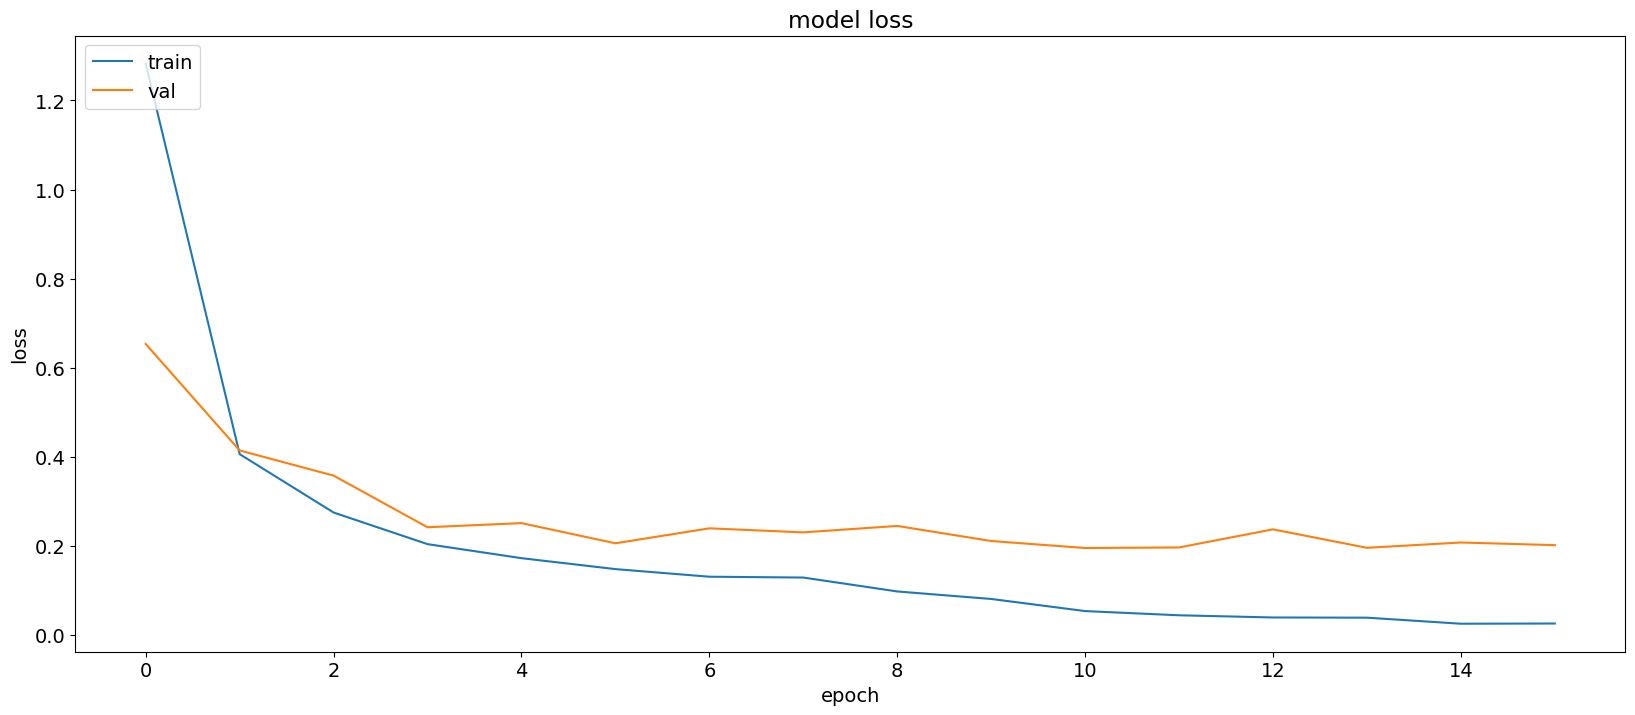

In [ ]:
#load the saved model
model = tf.keras.models.load_model("/content/model_inceptionv2.h5")
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

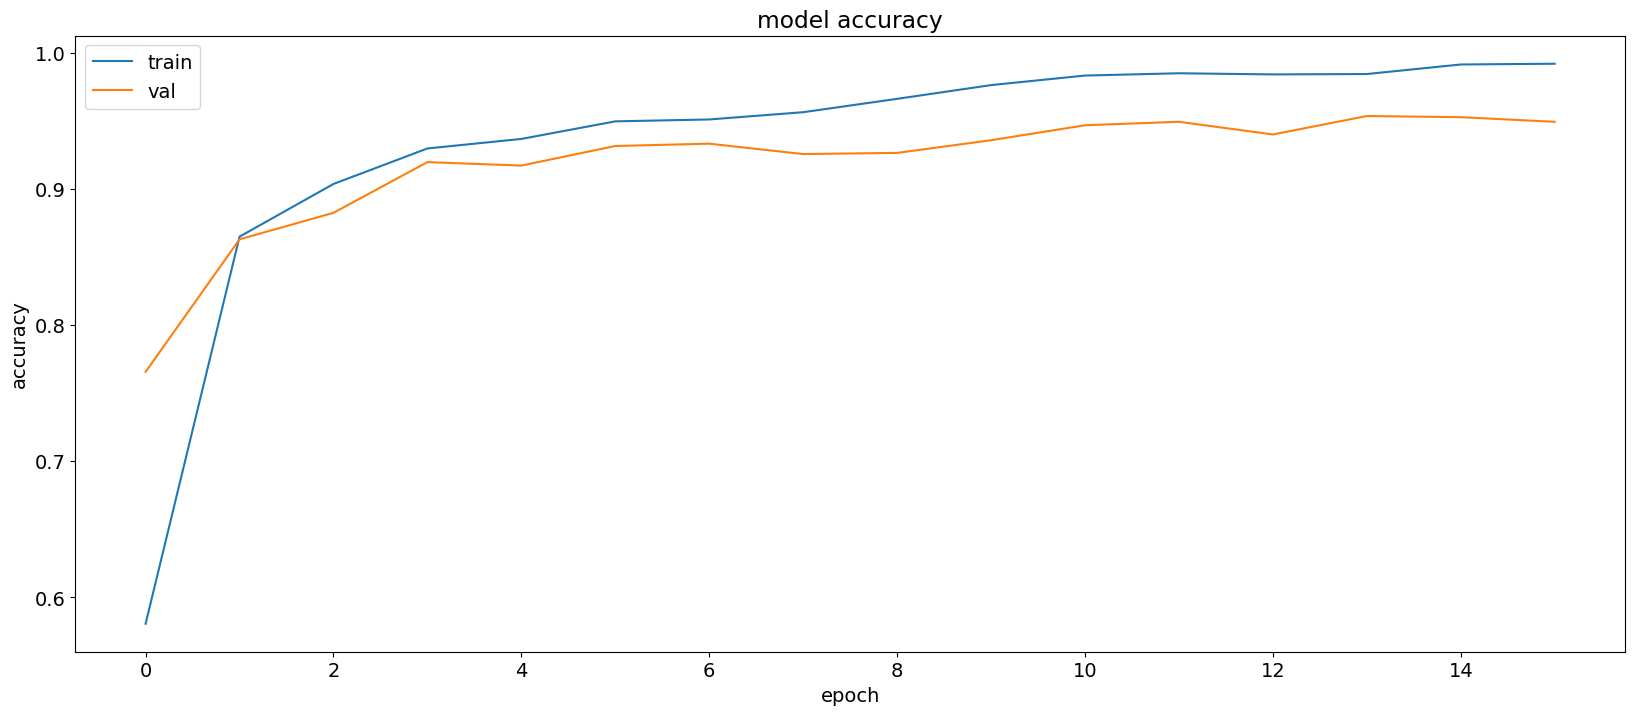

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_test = val_generator.classes
y_pred = model.predict(val_generator)
y_pred = np.argmax(y_pred,axis=1)

37/37 [==============================] - 33s 805ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,y_pred,target_names = label))

                           precision    recall  f1-score   support

              Black-grass       0.62      0.60      0.61        65
                 Charlock       0.99      1.00      0.99        97
                 Cleavers       0.99      0.96      0.97        71
         Common Chickweed       0.97      0.99      0.98       152
             Common wheat       0.98      0.93      0.95        55
                  Fat Hen       0.96      0.99      0.97       118
         Loose Silky-bent       0.82      0.86      0.84       163
                    Maize       1.00      0.96      0.98        55
        Scentless Mayweed       0.96      0.97      0.97       129
          Shepherds Purse       0.98      0.91      0.95        57
Small-flowered Cranesbill       1.00      0.98      0.99       124
               Sugar beet       0.98      0.97      0.97        96

                 accuracy                           0.94      1182
                macro avg       0.94      0.93      0.93    

Confusion Matrix:
[[ 39   0   0   0   1   0  25   0   0   0   0   0]
 [  0  97   0   0   0   0   0   0   0   0   0   0]
 [  0   0  68   1   0   1   0   0   1   0   0   0]
 [  0   0   0 151   0   0   1   0   0   0   0   0]
 [  0   0   1   0  51   1   1   0   0   0   0   1]
 [  0   0   0   1   0 117   0   0   0   0   0   0]
 [ 23   0   0   0   0   0 140   0   0   0   0   0]
 [  1   0   0   0   0   0   0  53   1   0   0   0]
 [  0   0   0   1   0   0   2   0 125   1   0   0]
 [  0   0   0   1   0   0   0   0   3  52   0   1]
 [  0   1   0   0   0   1   0   0   0   0 122   0]
 [  0   0   0   0   0   2   1   0   0   0   0  93]]


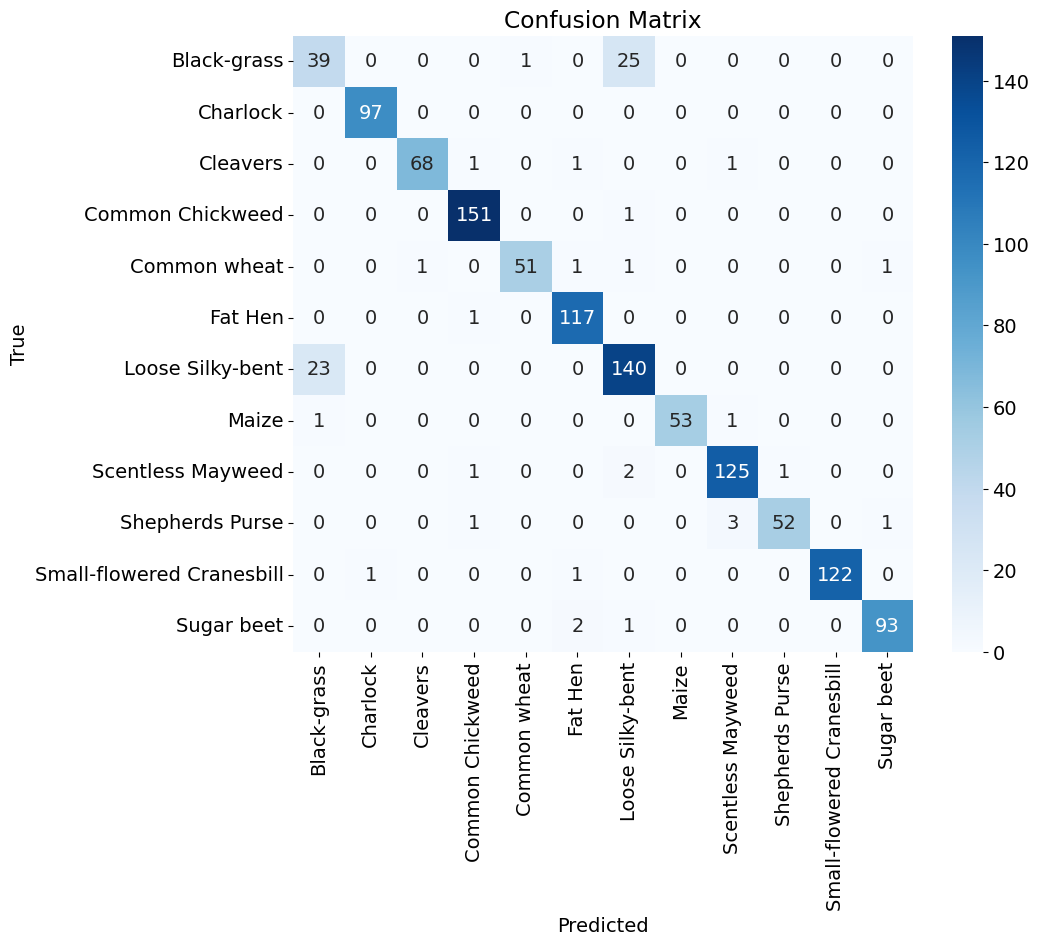

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Assuming y_test and y_pred contain your true labels and predicted labels
# Assuming label is a list of class labels

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Optionally, you can create a visual representation of the confusion matrix
# This is useful for a more intuitive understanding
import seaborn as sns
import matplotlib.pyplot as plt

# Define the labels for the confusion matrix
class_labels = label

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Save the model weights to a file
model.save_weights('model_weights_1.h5')